In [ ]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
!pip install tensorflow-privacy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-core 0.3.13 requires packaging<25,>=23.2, but you have packaging 22.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
xarray 2024.10.0 requires packaging>=23.1, but you have packaging 22.0 which is incompatible.


In [ ]:
!pip install imblearn

In [ ]:
import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
     auc,
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from sklearn.model_selection import StratifiedKFold



#Filtering errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Preprocess Data

In [ ]:
data  = pd.read_csv('/content/drive/MyDrive/BotNeTIoT-L01_label_NoDuplicates.csv', index_col = 0)

In [ ]:
# Binary problem
target_column = 'label'
display(data[target_column].unique())
num_classes = data[target_column].nunique()

array([0, 1])

In [ ]:
# Identify non-numeric columns (there are none)
print(data.select_dtypes(include='object').columns)

Index([], dtype='object')


In [ ]:
categorical_columns = [col for col in data.columns if col not in [target_column]] # Other columns

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split into training test and validation datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)



# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

#I reshaped it to be compatible with the expected inputs by LSTM model
X_train_numpy = X_train_scaled[categorical_columns].to_numpy()
X_train_lstm = X_train_numpy.reshape(X_train_numpy.shape[0], 1, X_train_numpy.shape[1])

X_valid_array = X_valid_scaled[categorical_columns].to_numpy()

X_valid_reshaped = X_valid_array.reshape(X_valid_array.shape[0], 1, X_valid_array.shape[1])

## Default LSTM

In [ ]:
from keras.callbacks import EarlyStopping
# Early stopping (make patience bigger if stopping too early)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Define the input_shape variable
#input_shape = X_train_lstm.shape[1:]
input_shape=(1, len(categorical_columns))

def create_teacher_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(units=48, input_shape=input_shape))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=48, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def create_student_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(units=48, input_shape=input_shape))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=48, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model
# Define your hyperparameters
num_teachers = 1
epsilon = 1.0
kfolds = 4
num_epochs = 4
bs = 32

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

for train_index, test_index in kfold.split(X_train_lstm, y_train):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Create and train teacher models for this fold
    teacher_models = []
    for i in range(num_teachers):
        teacher_model = create_teacher_model(input_shape, num_classes)
        teacher_model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=bs,
                          validation_data= (X_val_fold, y_val_fold),
                          callbacks=[early_stopping])  # Adjust epochs and batch_size as needed
        teacher_models.append(teacher_model)

    # Generate labels for the training data using teacher models
    def generate_labels(data):
        labels = []
        for model in teacher_models:
            labels.append(np.argmax(model.predict(data), axis = 1))
        return np.array(labels)  # Convert list of arrays to a single array

    # Define your student model
    student_model = create_student_model(input_shape, num_classes)

    # Generate labels for the training data using teacher models
    train_labels = generate_labels(X_train_fold)
    # train_labels = train_labels.reshape((-1, num_teachers, num_classes))
    student_y_train_fold = pd.Series(train_labels[0], index = y_train_fold.index)

    # Train the student model using the labels generated by the teacher models
    student_model.fit(X_train_fold, student_y_train_fold, epochs=num_epochs, batch_size=bs, callbacks=[early_stopping])  # Adjust epochs and batch_size as needed

    # Evaluate the student model on the validation set
    val_loss, val_accuracy = student_model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit the full model on the entire training set
teacher_models = []
for i in range(num_teachers):
    teacher_model = create_teacher_model(input_shape, num_classes)
    teacher_model.fit(X_train_lstm, y_train, epochs=num_epochs, batch_size=bs, validation_split = 0.2, callbacks=[early_stopping])  # Adjust epochs and batch_size as needed
    teacher_models.append(teacher_model)

# Generate labels for the training data using teacher models
def generate_labels(data):
    labels = []
    for model in teacher_models:
        labels.append(np.argmax(model.predict(data), axis = 1))
    return np.array(labels)  # Convert list of arrays to a single array

# Define your student model
student_model = create_student_model(input_shape, num_classes)

# Generate labels for the training data using teacher models
train_labels = generate_labels(X_train_lstm)
# train_labels = train_labels.reshape((-1, num_teachers, num_classes))
student_train_labels = pd.Series(train_labels[0], index = y_train.index)

# Train the student model using the labels generated by the teacher models
model_history =student_model.fit(X_train_lstm, student_train_labels, epochs=num_epochs, batch_size=bs,validation_split = 0.2, callbacks=[early_stopping])  # Adjust epochs and batch_size as needed


# # Predict on the test data
X_test_array = X_test_scaled[categorical_columns].to_numpy()
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], 1, X_test_array.shape[1])

# Predict on the test data
y_test_pred = student_model.predict(X_test_reshaped)

Epoch 1/4
42655/42655 [==============================] - 254s 6ms/step - loss: 0.0070 - accuracy: 0.9984 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 2/4
42655/42655 [==============================] - 247s 6ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 3/4
42655/42655 [==============================] - 247s 6ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 4/4
42655/42655 [==============================] - 95s 2ms/step
Epoch 1/4
42655/42655 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9988

42655/42655 [==============================] - 211s 5ms/step - loss: 0.0065 - accuracy: 0.9988
Epoch 2/4
42649/42655 [============================>.] - ETA: 0s - loss: 5.0744e-04 - accuracy: 0.9998

42655/42655 [==============================] - 205s 5ms/step - loss: 5.0737e-04 - accuracy: 0.9998
Epoch 3/4
42652/42655 [============================>.] - ETA: 0s - loss: 3.9395e-04 - accuracy: 0.9999

42655/42655 [==============================] - 205s 5ms/step - loss: 3.9394e-04 - accuracy: 0.9999
Epoch 4/4
42647/42655 [============================>.] - ETA: 0s - loss: 3.8024e-04 - accuracy: 0.9999

14219/14219 [==============================] - 41s 3ms/step - loss: 0.0021 - accuracy: 0.9997
Epoch 1/4
42655/42655 [==============================] - 235s 5ms/step - loss: 0.0076 - accuracy: 0.9988 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 2/4
42655/42655 [==============================] - 240s 6ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 3/4
42655/42655 [==============================] - 232s 5ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 9.9364e-04 - val_accuracy: 0.9997
Epoch 4/4
42655/42655 [==============================] - 93s 2ms/step
Epoch 1/4
42652/42655 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9984

42655/42655 [==============================] - 208s 5ms/step - loss: 0.0064 - accuracy: 0.9984
Epoch 2/4
42654/42655 [============================>.] - ETA: 0s - loss: 5.1318e-04 - accuracy: 0.9999

42655/42655 [==============================] - 203s 5ms/step - loss: 5.1317e-04 - accuracy: 0.9999
Epoch 3/4
42653/42655 [============================>.] - ETA: 0s - loss: 3.5219e-04 - accuracy: 0.9999

42655/42655 [==============================] - 204s 5ms/step - loss: 3.5218e-04 - accuracy: 0.9999
Epoch 4/4
42651/42655 [============================>.] - ETA: 0s - loss: 3.2245e-04 - accuracy: 0.9999

14219/14219 [==============================] - 41s 3ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 1/4
42655/42655 [==============================] - 235s 5ms/step - loss: 0.0072 - accuracy: 0.9984 - val_loss: 0.0017 - val_accuracy: 0.9996
Epoch 2/4
42655/42655 [==============================] - 234s 5ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 3/4
42655/42655 [==============================] - 232s 5ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 4/4
42655/42655 [==============================] - 94s 2ms/step
Epoch 1/4
42646/42655 [============================>.] - ETA: 0s - loss: 0.0069 - accuracy: 0.9990

42655/42655 [==============================] - 201s 5ms/step - loss: 0.0069 - accuracy: 0.9990
Epoch 2/4
42649/42655 [============================>.] - ETA: 0s - loss: 5.0657e-04 - accuracy: 0.9998

42655/42655 [==============================] - 199s 5ms/step - loss: 5.0653e-04 - accuracy: 0.9998
Epoch 3/4
42648/42655 [============================>.] - ETA: 0s - loss: 3.5504e-04 - accuracy: 0.9999

42655/42655 [==============================] - 198s 5ms/step - loss: 3.5498e-04 - accuracy: 0.9999
Epoch 4/4
42648/42655 [============================>.] - ETA: 0s - loss: 3.0608e-04 - accuracy: 0.9999

14219/14219 [==============================] - 41s 3ms/step - loss: 0.0024 - accuracy: 0.9997
Epoch 1/4
42655/42655 [==============================] - 244s 6ms/step - loss: 0.0073 - accuracy: 0.9981 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 2/4
42655/42655 [==============================] - 233s 5ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 8.7724e-04 - val_accuracy: 0.9997
Epoch 3/4
42655/42655 [==============================] - 230s 5ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0010 - val_accuracy: 0.9998
Epoch 4/4
42655/42655 [==============================] - 92s 2ms/step
Epoch 1/4
42646/42655 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9987

42655/42655 [==============================] - 202s 5ms/step - loss: 0.0065 - accuracy: 0.9987
Epoch 2/4
42648/42655 [============================>.] - ETA: 0s - loss: 6.9803e-04 - accuracy: 0.9998

42655/42655 [==============================] - 200s 5ms/step - loss: 6.9792e-04 - accuracy: 0.9998
Epoch 3/4
42646/42655 [============================>.] - ETA: 0s - loss: 5.6437e-04 - accuracy: 0.9999

42655/42655 [==============================] - 205s 5ms/step - loss: 5.6426e-04 - accuracy: 0.9999
Epoch 4/4
42653/42655 [============================>.] - ETA: 0s - loss: 4.5999e-04 - accuracy: 0.9999

14219/14219 [==============================] - 41s 3ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 1/4
45499/45499 [==============================] - 258s 6ms/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 2/4
45499/45499 [==============================] - 239s 5ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 3/4
45499/45499 [==============================] - 255s 6ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0014 - val_accuracy: 0.9997
Epoch 4/4
56873/56873 [==============================] - 123s 2ms/step
Epoch 1/4
45499/45499 [==============================] - 242s 5ms/step - loss: 0.0060 - accuracy: 0.9986 - val_loss: 5.4870e-04 - val_accuracy: 0.9998
Epoch 2/4
45499/45499 [==============================] - 255s 6ms/step - loss: 5.3222e-04 - accuracy: 0.9998 - val_loss: 3.1325e-04 - val_accuracy: 0.9999
Epoch 3/4
45499/45499 [==============================] - 254s 6ms/step - loss: 4.1114e-0

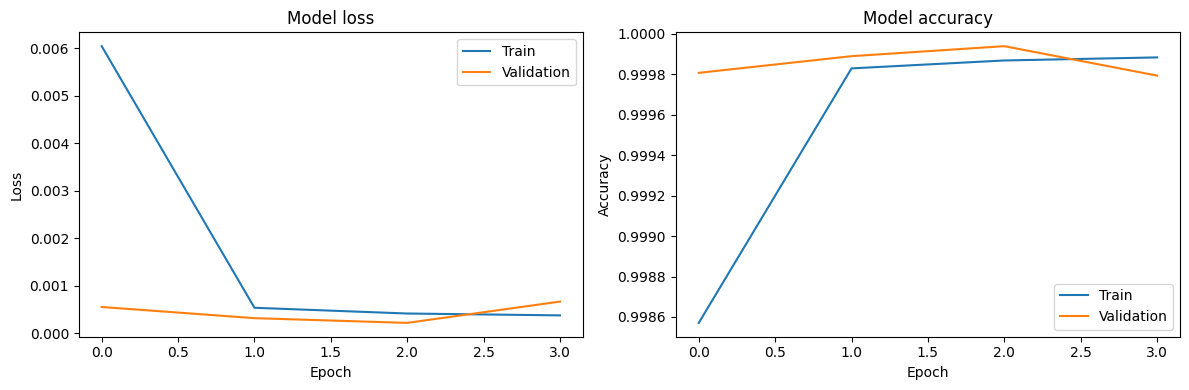

In [ ]:
# Function to plot loss curves
def plot_loss(history1, history2=None):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values for the first model
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values for the first model
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    if history2 is not None:
        # Plot training & validation loss values for the second model
        plt.subplot(1, 2, 1)
        plt.plot(history2.history['loss'], linestyle='dashed')
        plt.plot(history2.history['val_loss'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='upper right')

        # Plot training & validation accuracy values for the second model
        plt.subplot(1, 2, 2)
        plt.plot(history2.history['accuracy'], linestyle='dashed')
        plt.plot(history2.history['val_accuracy'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot loss curves
plot_loss(model_history)

In [ ]:
# Convert probability predictions to class labels
y_test_pred_classes_mlp = np.argmax(y_test_pred, axis=1)

# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp = accuracy_score(y_test, y_test_pred_classes_mlp)
precision_mlp = precision_score(y_test, y_test_pred_classes_mlp, average='macro')
recall_mlp = recall_score(y_test, y_test_pred_classes_mlp, average='macro')
f1_mlp = f1_score(y_test, y_test_pred_classes_mlp, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp}")
print(f"Precision = {precision_mlp}")
print(f"Recall = {recall_mlp}")
print(f"F1 Score =  {f1_mlp}")

Average cross-validation loss: 0.0018813494534697384
Average cross-validation accuracy: 0.999721422791481
MLP Model:
Accuracy =  0.9996455917381665
Precision = 0.9997038546014434
Recall = 0.9992324430362955
F1 Score =  0.9994679265829756


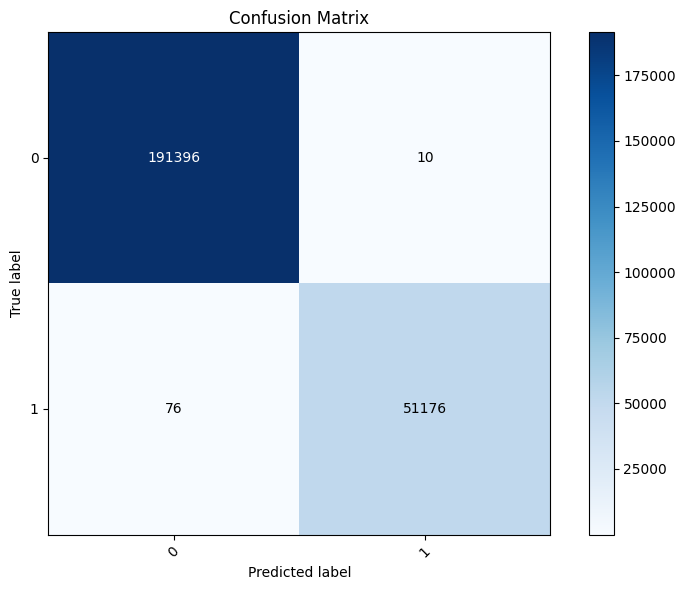

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes_mlp)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = [0,1]

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

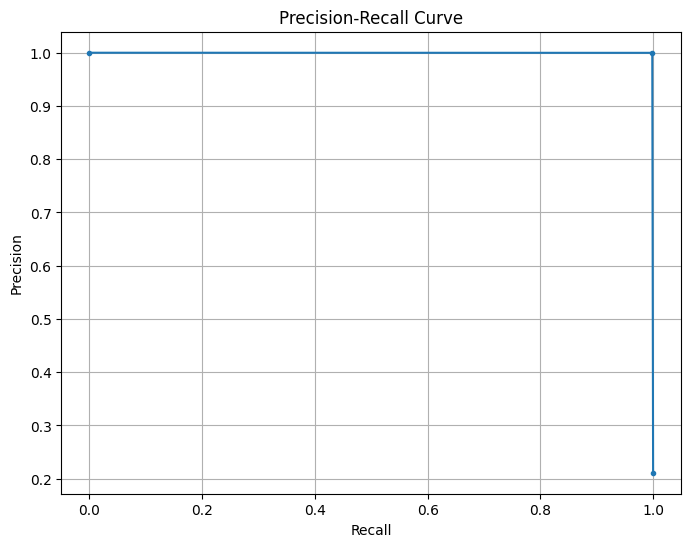

In [ ]:
# Calculate precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_classes_mlp)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

## Pate Privacy

In [ ]:
# Define the input_shape variable
#input_shape = X_train_lstm.shape[1:]
input_shape=(1, len(categorical_columns))

def create_teacher_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(units=48, input_shape=input_shape))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=48, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Set hyperparameters for privacy-preserving training
batch_size = 128  # Number of samples in each training batch
l2_norm_clip = 1.5  # Upper bound on the L2 norm of model's gradients
noise_multiplier = 1.3  # Multiplier for the Gaussian noise added to gradients
num_microbatches = 1  # Number of microbatches for training
learning_rate = 0.003  # Learning rate for the optimizer

# Ensure that batch size is a multiple of the number of microbatches
if batch_size % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

# Initialize a differentially private stochastic gradient descent optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

def create_student_model_privacy(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(units=48, input_shape=input_shape))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=48, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model outside the loop if the architecture and optimizer are consistent
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model



# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define your hyperparameters
num_teachers = 1
epsilon = 1.0
kfolds = 4
num_epochs = 4
bs = 32

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

for train_index, test_index in kfold.split(X_train_lstm, y_train):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Create and train teacher models for this fold
    teacher_models = []
    for i in range(num_teachers):
        teacher_model = create_teacher_model(input_shape, num_classes)
        teacher_model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=bs,
                          validation_data= (X_val_fold, y_val_fold) ,
                          callbacks=[early_stopping])  # Adjust epochs and batch_size as needed
        teacher_models.append(teacher_model)

    # Generate labels for the training data using teacher models
    def generate_labels(data):
        labels = []
        for model in teacher_models:
            labels.append(np.argmax(model.predict(data), axis = 1))
        return np.array(labels)  # Convert list of arrays to a single array

    # Define your student model
    student_model_privacy = create_student_model_privacy(input_shape, num_classes)

    # Generate labels for the training data using teacher models
    train_labels = generate_labels(X_train_fold)
    # train_labels = train_labels.reshape((-1, num_teachers, num_classes))
    student_y_train_fold = pd.Series(train_labels[0], index = y_train_fold.index)

    # Train the student model using the labels generated by the teacher models
    student_model_privacy.fit(X_train_fold, student_y_train_fold, epochs=num_epochs, batch_size=bs,
                              callbacks=[early_stopping])  # Adjust epochs and batch_size as needed

    # Evaluate the student model on the validation set
    val_loss, val_accuracy = student_model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit the full model on the entire training set
teacher_models = []
for i in range(num_teachers):
    teacher_model = create_teacher_model(input_shape, num_classes)
    teacher_model.fit(X_train_lstm, y_train, epochs=num_epochs, batch_size=bs,validation_split = 0.2, callbacks=[early_stopping])  # Adjust epochs and batch_size as needed
    teacher_models.append(teacher_model)

# Generate labels for the training data using teacher models
def generate_labels(data):
    labels = []
    for model in teacher_models:
        labels.append(np.argmax(model.predict(data), axis = 1))
    return np.array(labels)  # Convert list of arrays to a single array

# Define your student model
student_model_privacy = create_student_model_privacy(input_shape, num_classes)

# Generate labels for the training data using teacher models
train_labels = generate_labels(X_train_lstm)
# train_labels = train_labels.reshape((-1, num_teachers, num_classes))
student_train_labels = pd.Series(train_labels[0], index = y_train.index)

# Train the student model using the labels generated by the teacher models
model_history_privacy = student_model_privacy.fit(X_train_lstm, student_train_labels, epochs=num_epochs, batch_size=bs,validation_split = 0.2, callbacks=[early_stopping])  # Adjust epochs and batch_size as needed


# # Predict on the test data
X_test_array = X_test_scaled[categorical_columns].to_numpy()


Epoch 1/4
42655/42655 [==============================] - 243s 6ms/step - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 2/4
42655/42655 [==============================] - 233s 5ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 3/4
42655/42655 [==============================] - 231s 5ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 4/4
42655/42655 [==============================] - 94s 2ms/step
Epoch 1/4
42654/42655 [============================>.] - ETA: 0s - loss: 0.3299 - accuracy: 0.9770

42655/42655 [==============================] - 966s 22ms/step - loss: 0.3299 - accuracy: 0.9770
Epoch 2/4
42655/42655 [==============================] - ETA: 0s - loss: 1.0947 - accuracy: 0.9839

42655/42655 [==============================] - 956s 22ms/step - loss: 1.0947 - accuracy: 0.9839
Epoch 3/4
42653/42655 [============================>.] - ETA: 0s - loss: 1.7171 - accuracy: 0.9892

42655/42655 [==============================] - 924s 22ms/step - loss: 1.7171 - accuracy: 0.9892
Epoch 4/4
42653/42655 [============================>.] - ETA: 0s - loss: 2.8551 - accuracy: 0.9887

14219/14219 [==============================] - 41s 3ms/step - loss: 0.0022 - accuracy: 0.9996
Epoch 1/4
42655/42655 [==============================] - 234s 5ms/step - loss: 0.0076 - accuracy: 0.9986 - val_loss: 0.0016 - val_accuracy: 0.9997
Epoch 2/4
42655/42655 [==============================] - 246s 6ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 3/4
42655/42655 [==============================] - 248s 6ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 4/4
42655/42655 [==============================] - 93s 2ms/step
Epoch 1/4
42655/42655 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.9787

42655/42655 [==============================] - 1021s 24ms/step - loss: 0.2803 - accuracy: 0.9787
Epoch 2/4
42655/42655 [==============================] - ETA: 0s - loss: 1.1236 - accuracy: 0.9854

42655/42655 [==============================] - 1006s 24ms/step - loss: 1.1236 - accuracy: 0.9854
Epoch 3/4
37803/42655 [=========================>....] - ETA: 1:53 - loss: 1.9758 - accuracy: 0.9875

KeyboardInterrupt: 

In [ ]:
# Predict on the test data
y_test_pred_mlp_privacy = student_model_privacy.predict(X_test_reshaped)

# # Apply the threshold to make binary predictions
y_test_pred_binary_mlp_privacy = y_test_pred_mlp_privacy.argmax(axis=1)

7584/7584 [==============================] - 17s 2ms/step


In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp_privacy = accuracy_score(y_test, y_test_pred_binary_mlp_privacy)
precision_mlp_privacy = precision_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
recall_mlp_privacy = recall_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
f1_mlp_privacy = f1_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp_privacy}")
print(f"Precision = {precision_mlp_privacy}")
print(f"Recall = {recall_mlp_privacy}")
print(f"F1 Score =  {f1_mlp_privacy}")

Average cross-validation loss: 0.0021909421775490046
Average cross-validation accuracy: 0.9996307492256165
MLP Model:
Accuracy =  0.9963941019871588
Precision = 0.9950273900714922
Recall = 0.9941425484587596
F1 Score =  0.9945841771159301


In [ ]:
# Plot loss curves
plot_loss(model_history_privacy)

NameError: name 'model_history_privacy' is not defined

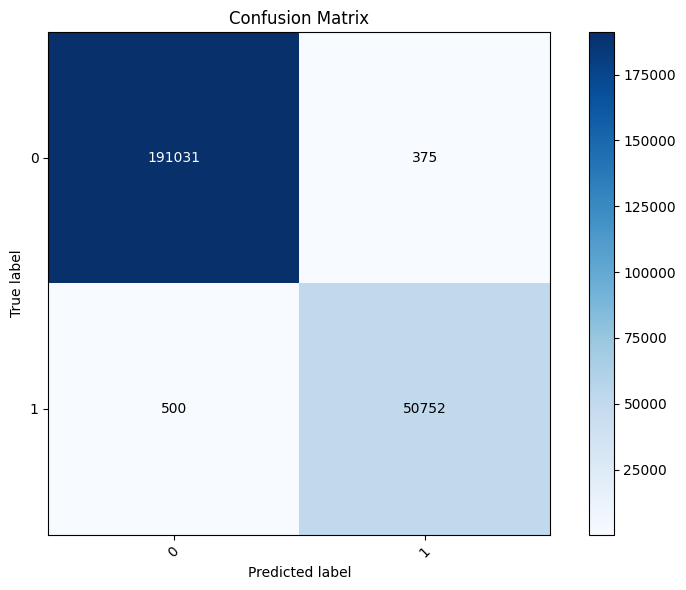

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary_mlp_privacy)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = [0,1]

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

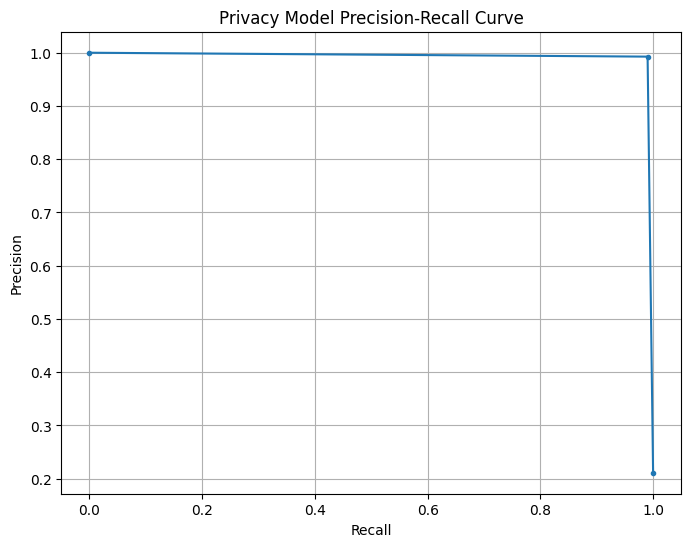

In [ ]:
# Calculate precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_binary_mlp_privacy)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Privacy Model Precision-Recall Curve')
plt.grid(True)
plt.show()

In [ ]:
# Compute privacy budget
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_lstm),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    num_epochs=30,
    delta=1e-5
)

In [ ]:
print(privacy_report)

DP-SGD performed over 1819930 examples with 128 examples per iteration, noise
multiplier 1.3 for 30 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        74.229
    Epsilon assuming Poisson sampling (*):                      1.446

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.



## Combine

In [ ]:
# Create DataFrame
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Regular': [accuracy_mlp, precision_mlp, recall_mlp, f1_mlp],
    'Privacy': [accuracy_mlp_privacy, precision_mlp_privacy, recall_mlp_privacy, f1_mlp_privacy]
}

df = pd.DataFrame(data)

# Print DataFrame
display(df)

,Metric,Regular,Privacy
0,Accuracy,0.999646,0.996394
1,Precision,0.999704,0.995027
2,Recall,0.999232,0.994143
3,F1 Score,0.999468,0.994584


In [ ]:
plot_loss(model_history, model_history_privacy)

NameError: name 'model_history_privacy' is not defined